<a href="https://colab.research.google.com/github/camilletulipe06-wq/Quantitative-Methods-2---Research-Project/blob/main/Part_3_coding_(Multiple_Regression).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving QM 2 projects data .xlsx to QM 2 projects data .xlsx


In [ ]:
import pandas as pd
import numpy as np

file = list(uploaded.keys())[0]
print("Using file:", file)


xls = pd.ExcelFile(file)
print("Sheets found:", xls.sheet_names)


LOW = ["Madagascar", "Burundi", "Chad"]
MID = ["Egypt", "Algeria", "Botswana"]
HIGH = ["Seychelles ", "Bahrain", "Trinidad and Tobago"]

SHEET = "data for countries in part 3"


df = pd.read_excel(file, sheet_name=SHEET)


df.columns = [c.strip().lower() for c in df.columns]


rename_map = {
    "lower secondary school completion rate": "education",
    "secondary school completion rate": "education",
    "maternal mortality": "mmr",
    "income level": "income_level",
    "income level ": "income_level",
    "year": "year",
    "country": "country",
}
df = df.rename(columns=rename_map)


keep = ["country", "year", "education", "mmr"]
df = df[[c for c in keep if c in df.columns]].copy()


df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["education"] = pd.to_numeric(df["education"], errors="coerce")
df["mmr"] = pd.to_numeric(df["mmr"], errors="coerce")


picked = set(LOW + MID + HIGH)
df = df[df["country"].isin(picked)].copy()


def group(c):
    if c in LOW: return "Low"
    if c in MID: return "Middle"
    if c in HIGH: return "High"
    return np.nan

df["income_group"] = df["country"].map(group)


df = df.dropna(subset=["year", "mmr"])
df["ln_mmr"] = np.log(df["mmr"])


base = df.dropna(subset=["education", "income_group", "ln_mmr"]).copy()

print("Rows total:", len(df))
print("Rows usable for regressions (has education):", len(base))
print("\nCountries loaded:")
print(base[["country","income_group"]].drop_duplicates().sort_values(["income_group","country"]))

base.head(10)


Using file: QM 2 projects data .xlsx
Sheets found: ['IGNORE THISSS data for countrie', 'data for countries in part 3', 'IGNORE THISSSSS data for part 1', 'data for part 1', 'IGNOREEEEE general data for the', 'general data for the project', 'IGNOREEE data for the seychelle', 'data for the seychelles', 'IGNOREEE data for egypt', 'data for egypt', 'IGNORE THISSS data for madagasc', 'data for madagascar', 'IGNOREEE data by income groups', 'data by income group']
Rows total: 351
Rows usable for regressions (has education): 217

Countries loaded:
                 country income_group
241              Bahrain         High
323          Seychelles          High
280  Trinidad and Tobago         High
0                Burundi          Low
43                  Chad          Low
80            Madagascar          Low
120              Algeria       Middle
160             Botswana       Middle
209                Egypt       Middle


,country,year,education,mmr,income_group,ln_mmr
0,Burundi,1985,0.58680,1428.0,Low,7.264030
1,Burundi,1986,0.67752,1441.0,Low,7.273093
2,Burundi,1987,1.34105,1446.0,Low,7.276556
3,Burundi,1988,1.47631,1519.0,Low,7.325808
4,Burundi,1989,1.54953,1511.0,Low,7.320527
5,Burundi,1990,1.87756,1515.0,Low,7.323171
7,Burundi,1992,3.32890,1464.0,Low,7.288928
8,Burundi,1993,3.51180,1801.0,Low,7.496097
19,Burundi,2004,6.68054,687.0,Low,6.532334
20,Burundi,2005,7.14739,685.0,Low,6.529419


In [ ]:
import statsmodels.formula.api as smf


base = df.dropna(subset=["ln_mmr","education","year","income_group","country"]).copy()


m1 = smf.ols("ln_mmr ~ education + year", data=base).fit(
    cov_type="cluster", cov_kwds={"groups": base["country"]}
)


m2 = smf.ols("ln_mmr ~ C(income_group) + year", data=base).fit(
    cov_type="cluster", cov_kwds={"groups": base["country"]}
)


m3 = smf.ols("ln_mmr ~ education + C(income_group) + year", data=base).fit(
    cov_type="cluster", cov_kwds={"groups": base["country"]}
)

print(m1.summary())
print(m2.summary())
print(m3.summary())


                            OLS Regression Results                            
Dep. Variable:                 ln_mmr   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     22.60
Date:                Fri, 02 Jan 2026   Prob (F-statistic):           0.000511
Time:                        09:47:09   Log-Likelihood:                -219.45
No. Observations:                 217   AIC:                             444.9
Df Residuals:                     214   BIC:                             455.0
Df Model:                           2                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.2029     16.257      1.120      0.2

In [ ]:
print("Adj R² (Edu + Year):", round(m1.rsquared_adj, 3))
print("Adj R² (IncomeGrp + Year):", round(m2.rsquared_adj, 3))
print("Adj R² (Both + Year):", round(m3.rsquared_adj, 3))

dEdu = m3.rsquared_adj - m2.rsquared_adj
dDev = m3.rsquared_adj - m1.rsquared_adj
print("\nExtra explained (Adj R²) from adding EDUCATION:", round(dEdu, 3))
print("Extra explained (Adj R²) from adding INCOME GROUP:", round(dDev, 3))


Adj R² (Edu + Year): 0.767
Adj R² (IncomeGrp + Year): 0.868
Adj R² (Both + Year): 0.868

Extra explained (Adj R²) from adding EDUCATION: -0.001
Extra explained (Adj R²) from adding INCOME GROUP: 0.101


These results compare how well education and income group explain variation in maternal mortality (ln(MMR)) once we control for time (year). When we include education + year, the model explains a large share of the variation (Adj. R² = 0.767). However, when we include income group + year, the model explains even more (Adj. R² = 0.868). Importantly, adding education to the income-group model does not improve fit (Adj. R² stays 0.868 and ΔAdj. R² ≈ −0.001), meaning education provides essentially no additional explanatory power once income group and year are already accounted for. In contrast, adding income group to the education model increases fit by about 10 percentage points (ΔAdj. R² ≈ +0.101). Overall, for our selected countries, the results suggest that income group is the stronger predictor of ln(MMR) compared with education, after controlling for global time trends. This also supports our earlier issue: much of education’s apparent effect is tied to time trends and country context, so once those are included, education has little independent influence in this dataset.

This does not mean education is ‘unimportant’ in real life. It means that in our sample and model, education is so closely tied to (1) time trends (education generally rises over years while MMR generally falls) and (2) income context (income group/country differences) that once we control for year + income group, there isn’t enough independent variation in education left to explain additional differences in ln(MMR). So, education’s role here looks more like a pathway that moves together with development and time, rather than an extra predictor that explains MMR beyond those factors.

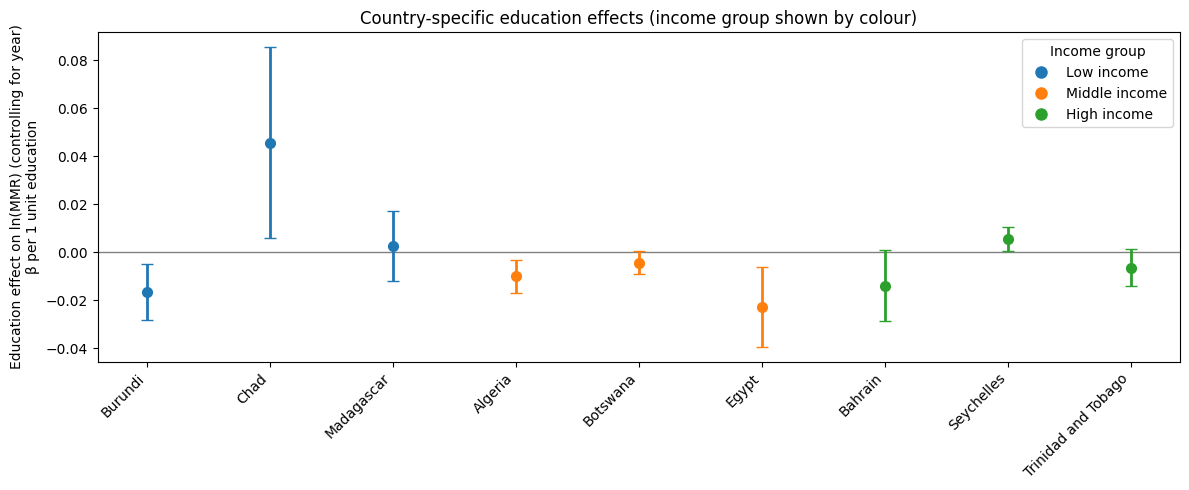

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


df["country"] = df["country"].astype(str).str.strip()

base = df.dropna(subset=["ln_mmr","education","year","country"]).copy()


country_to_group = {

    "Madagascar": "Low income",
    "Burundi": "Low income",
    "Chad": "Low income",

    "Egypt": "Middle income",
    "Algeria": "Middle income",
    "Botswana": "Middle income",

    "Seychelles": "High income",
    "Bahrain": "High income",
    "Trinidad and Tobago": "High income"
}

base["income_group_lab"] = base["country"].map(country_to_group)


base = base.dropna(subset=["income_group_lab"]).copy()


group_order = ["Low income", "Middle income", "High income"]
base["income_group_lab"] = pd.Categorical(base["income_group_lab"],
                                         categories=group_order, ordered=True)


m_country = smf.ols(
    "ln_mmr ~ 0 + year + C(country) + education:C(country)",
    data=base
).fit(cov_type="cluster", cov_kwds={"groups": base["country"]})


rows = []
for c in sorted(base["country"].unique()):
    term1 = f"education:C(country)[{c}]"
    term2 = f"education:C(country)[T.{c}]"

    if term1 in m_country.params.index:
        term = term1
    elif term2 in m_country.params.index:
        term = term2
    else:
        continue

    b  = m_country.params[term]
    se = m_country.bse[term]
    inc = base.loc[base["country"] == c, "income_group_lab"].iloc[0]
    rows.append([c, inc, b, se])

coef_df = pd.DataFrame(rows, columns=["country","income_group","beta","se"])
coef_df["lo"] = coef_df["beta"] - 1.96*coef_df["se"]
coef_df["hi"] = coef_df["beta"] + 1.96*coef_df["se"]


coef_df["income_group"] = pd.Categorical(coef_df["income_group"],
                                        categories=group_order, ordered=True)
coef_df = coef_df.sort_values(["income_group", "country"]).reset_index(drop=True)


colors = {"Low income":"tab:blue", "Middle income":"tab:orange", "High income":"tab:green"}
coef_df["color"] = coef_df["income_group"].astype(str).map(colors)


plt.figure(figsize=(12,5))
plt.axhline(0, color="grey", linewidth=1)

for i, r in coef_df.iterrows():
    yerr = [[r["beta"] - r["lo"]], [r["hi"] - r["beta"]]]
    plt.errorbar(
        i, r["beta"],
        yerr=yerr,
        fmt="o",
        color=r["color"],
        ecolor=r["color"],
        elinewidth=2,
        capsize=4,
        markersize=7,
        zorder=3
    )

plt.xticks(np.arange(len(coef_df)), coef_df["country"], rotation=45, ha="right")
plt.ylabel("Education effect on ln(MMR) (controlling for year)\nβ per 1 unit education")
plt.title("Country-specific education effects (income group shown by colour)")


handles = [
    plt.Line2D([0],[0], marker='o', linestyle='',
               markerfacecolor=colors[g], markeredgecolor=colors[g],
               color='w', label=g, markersize=8)
    for g in group_order
]
plt.legend(handles=handles, title="Income group", frameon=True)

plt.tight_layout()
plt.show()


Counts by income_group_lab (should NOT be empty):
income_group_lab
Low income       77
Middle income    72
High income      68
Name: count, dtype: int64 



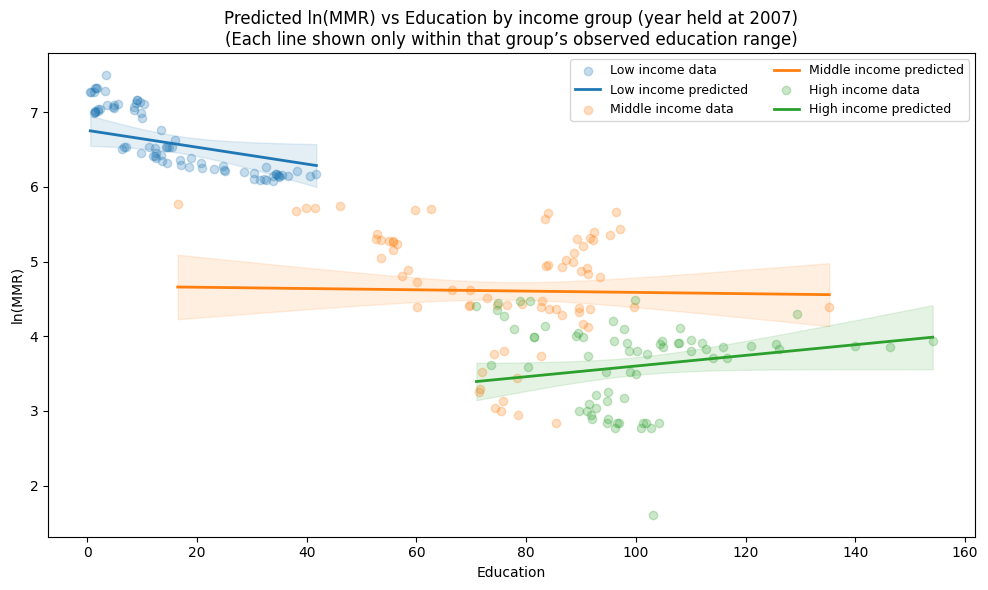

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

year_hold = 2007

group_order = ["Low income", "Middle income", "High income"]
colors = {"Low income":"tab:blue", "Middle income":"tab:orange", "High income":"tab:green"}


tmp = base["income_group"].astype(str).str.strip().str.lower()


map_num = {"0":"Low income", "1":"Middle income", "2":"High income"}


map_txt = {"low":"Low income", "middle":"Middle income", "high":"High income"}

base["income_group_lab"] = tmp.map(map_txt).fillna(tmp.map(map_num))


base["income_group_lab"] = base["income_group_lab"].fillna(base["income_group"].astype(str).str.strip())


base["income_group_lab"] = pd.Categorical(base["income_group_lab"], categories=group_order, ordered=True)

print("Counts by income_group_lab (should NOT be empty):")
print(base["income_group_lab"].value_counts(dropna=False), "\n")


m_int = smf.ols("ln_mmr ~ education * C(income_group_lab) + year", data=base).fit()


plt.figure(figsize=(10,6))

plotted_any = False

for g in group_order:
    sub = base[base["income_group_lab"] == g].dropna(subset=["education","ln_mmr","year"])
    if len(sub) < 3:
        print(f"Skipping {g}: only {len(sub)} usable rows")
        continue

    plotted_any = True

    x_min, x_max = sub["education"].min(), sub["education"].max()
    x_grid = np.linspace(x_min, x_max, 80)

    pred_df = pd.DataFrame({
        "education": x_grid,
        "income_group_lab": g,
        "year": year_hold
    })

    pred = m_int.get_prediction(pred_df).summary_frame(alpha=0.05)

    plt.scatter(sub["education"], sub["ln_mmr"],
                alpha=0.25, color=colors[g], label=f"{g} data")

    plt.plot(x_grid, pred["mean"], color=colors[g], linewidth=2, label=f"{g} predicted")
    plt.fill_between(x_grid, pred["mean_ci_lower"], pred["mean_ci_upper"],
                     color=colors[g], alpha=0.12)

if not plotted_any:
    print("\nNothing was plotted — check the counts printed above. Your group labels still don't match.")

plt.xlabel("Education")
plt.ylabel("ln(MMR)")
plt.title(f"Predicted ln(MMR) vs Education by income group (year held at {year_hold})\n"
          f"(Each line shown only within that group’s observed education range)")
plt.legend(ncols=2, fontsize=9)
plt.tight_layout()
plt.show()


This figure shows the predicted ln(MMR) (maternal mortality) as education changes, plotted separately for low-, middle-, and high-income groups, with year held constant at 2007. The dots are the observed country–year data points, and the coloured lines are the model’s fitted relationships within each income group’s actual education range (so we don’t extrapolate beyond what that group contains). Overall, the plot highlights that income group shifts the baseline level of ln(MMR) strongly (the groups sit at different vertical levels), while the education–MMR slope within each income group is relatively weak/uncertain and differs across groups. This supports the Part 3 idea that development context (income group) explains much more of the cross-country difference in MMR, whereas education adds only a limited extra effect once development level (and time) are accounted for.